In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '..')

from sim.LoadBalancer import LoadBalancer
from sim.Source import ArrivalSchedule, Source
from sim.Environment import Environment
import numpy as np
import random
import matplotlib.pyplot as plt
import math

### Implementing the Epsilon Greedy algorithm in our LoadBalancer structure
We use the LoadBalancer as the base class and import the epsilong greedy algorithm

In [98]:
class GreedyEpsilonLoadBalancer(LoadBalancer):
    def __init__(self, nServers, environment, model, processReward=1, cancelReward=-10, serverReward=-300, eta=0.15, nServerRange = (1,40), usePartialFit=False, periodLength =1):
        """
            model: obj with methods predict, fit, fit_partial etc.
            eta: float or callable(periodIndex: int -> float)
        """
        super().__init__(nServers, environment)
        self.model = model # a model that takes (N_t, X_t) and predicts the reward of the next time period
        self.agg = {'totalInQueue': np.mean,'requestStartWaiting':np.sum,'arrivalEvent':np.sum,'requestWaitingTime': np.mean,'requestProcessed':np.sum,'totalTimeInSystem':np.mean,'requestCancelled':np.sum}
        self.currentPeriod = 0
        self.processReward, self.cancelReward, self.serverReward = processReward, cancelReward, serverReward
        self.eta = eta
        self.nServerRange = nServerRange #the range for the bernoulli to sample from
        self.usePartialFit = usePartialFit
        self.periodLength = periodLength
        self.X = None #store the complete feature dataset here
        self.y = None #store the complete target dataset here s

    def getEta(self):
        if callable(self.eta):
            return self.eta(self.currentPeriod)
        else:
            return self.eta

    def getPreviousPeriodContext(self):
        """
        Get the context from the period that just ended (potentially add lags here from previous periods)
        """
        previousPeriodData = self.environment.getPeriodLog() #returns {key: values}
        previousPeriodContext = {key: self.agg[key](vals) for key,vals in previousPeriodData.items() if key in self.agg.keys()} #apply aggregation: go from lists to scalars
        previousPeriodContext ={key:val if not np.isnan(val) else 0 for key,val in previousPeriodContext.items()}
        previousPeriodContext ={key:previousPeriodContext[key] if key in previousPeriodContext.keys() else 0 for key in self.agg.keys()}

        self.environment.resetPeriod()
        return previousPeriodContext

    def getPreviousPeriodReward(self, context: dict):
        """
        Get the reward of the period that just ended
        """
        nProcessed = context['requestProcessed']
        nCancelled = context['requestCancelled'] if 'requestCancelled' in context.keys() else 0
        nServers = self.nServers
        reward = nProcessed * self.processReward + nCancelled * self.cancelReward + self.periodLength/60/60*nServers*self.serverReward
        print(nProcessed, nCancelled, nServers, reward)
        return reward

    def findModelOptimum(self, context):
        max = -math.inf
        maxArg = 0
        for n in range(self.nServerRange[0], self.nServerRange[1]): #implement better optimization here
            X =  np.append(np.array(list(context.values())), n)
            rewardHat = self.model.predict(X[None,:])[0]
            if rewardHat > max:
                maxArg = n
                max = rewardHat
        print("Max reward for", rewardHat, maxArg)
        return maxArg

    def getNextPeriodNumberOfServers(self, context):
        #take random action or input the context into the model and maximizy the output w.r.t N
        draw = random.random()
        eta = self.getEta()
        self.environment.logData('eta', eta)
        nServers = None
        if draw < eta or self.currentPeriod <= 1: #on first iteration the model is not fitted
            #Take random action
            self.environment.logData("greedyEpsilonActionType", 0)
            nServers = random.randint(self.nServerRange[0], self.nServerRange[1])
        else:
            self.environment.logData("greedyEpsilonActionType", 1)
            nServers = self.findModelOptimum(context) 

        return nServers
        
    def updateModel(self, context, reward):
        #update the model using the context, nServers and observed reward
        if self.currentPeriod > 0:
            newY = np.array([reward])
            self.y = np.append(self.y, newY[None,:], axis=0) if self.y is not None else newY[None,:]
            if not self.usePartialFit:
                #print(self.X.shape,self.y.shape)
                self.model = self.model.fit(self.X, self.y) #make sure the hat the last period x is ignored
                print(self.model.score(self.X, self.y))
            else:
                self.model = self.model.partial_fit(self.X, self.y) #make sure the hat the last period x is ignored
                print(self.model.score(self.X, self.y))

    def updateX(self, context, nOptimal):
        newX = np.array(list(context.values()) + [nOptimal]) #+ [reward] #add the current nServers to X
        self.X = np.append(self.X, newX[None,:], axis=0) if self.X is not None else newX[None,:] #update the data 

    def onPeriodEnd(self):
        #Get the reward of the current period
        previousPeriodContext = self.getPreviousPeriodContext()
        #print(previousPeriodContext)
        previousPeriodReward = self.getPreviousPeriodReward(previousPeriodContext)
        self.environment.logData("reward", previousPeriodReward)
        self.updateModel(previousPeriodContext, previousPeriodReward)
        if self.currentPeriod>0:print(self.X.shape,self.y.shape)
        nextPeriodNServers = self.getNextPeriodNumberOfServers(previousPeriodContext)
        self._setNumberOfServers(nextPeriodNServers)
        self.updateX(previousPeriodContext, nextPeriodNServers)
        self.currentPeriod+=1
        print(self.nServers)



### Test for fixed rate

In [17]:
from BinarySearch import binaryServerSearch

opt = binaryServerSearch(10,[0,40])
print(opt)

17


In [4]:
def sigmoid(x):
      return 1 / (1 + np.exp(-x))

In [99]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

stopTime = 1*24*60*60
env = Environment(stopTime=stopTime)

#model = LinearRegression()
#model = DecisionTreeRegressor()
model  = MLPRegressor(hidden_layer_sizes=[10], activation='tanh')
model  =RandomForestRegressor(n_estimators=10)
eta = lambda t: sigmoid(2-0.05*t)
#eta = 0.4
#sigmoid(2/(0.1*t+2)-0.5)
loadBalancer = GreedyEpsilonLoadBalancer(nServers=10, environment=env, model = model, eta=eta, nServerRange=[10,30], usePartialFit=False)

requestTypes = [(0.5,1,0.1,10), (0.5,2,0.2,10)] #(prob, mu, sigma, cancelTime)
arrivalsPerSecond = 10
source = Source(arrivalsPerSecond, requestTypes, loadBalancer, env)

schedule = np.array([arrivalsPerSecond]) #12 periods
periodLength = 1*60*60 #half an hour per period -> schedule repeated two times in 12 hours
arrivalSchedule = ArrivalSchedule(periodLength,arrivalSchedule=schedule, environment=env, loadBalancer=loadBalancer, source=source)
env.run(debug=False)

36016 2077 10 15245.166666666666
19
36133 18 19 35951.416666666664
nan
(1, 8) (1, 1)
15


<ipython-input-98-9b8b24af2459>:83: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.model = self.model.fit(self.X, self.y) #make sure the hat the last period x is ignored
/Users/julianvanmeggelen/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


36018 219 15 33826.75
0.6000000000000028
(2, 8) (2, 1)
14


<ipython-input-98-9b8b24af2459>:83: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.model = self.model.fit(self.X, self.y) #make sure the hat the last period x is ignored


35954 641 14 29542.833333333332
0.8778123339237176
(3, 8) (3, 1)
26


<ipython-input-98-9b8b24af2459>:83: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.model = self.model.fit(self.X, self.y) #make sure the hat the last period x is ignored


36237 0.0 26 36234.833333333336
0.7452871148625893
(4, 8) (4, 1)
Max reward for 33210.775 15
15


<ipython-input-98-9b8b24af2459>:83: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.model = self.model.fit(self.X, self.y) #make sure the hat the last period x is ignored


35951 213 15 33819.75
0.6408139009459366
(5, 8) (5, 1)
29


<ipython-input-98-9b8b24af2459>:83: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.model = self.model.fit(self.X, self.y) #make sure the hat the last period x is ignored


36059 0.0 29 36056.583333333336
0.7888604617756495
(6, 8) (6, 1)
Max reward for 34084.433333333334 23
23


<ipython-input-98-9b8b24af2459>:83: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.model = self.model.fit(self.X, self.y) #make sure the hat the last period x is ignored


36071 0.0 23 36069.083333333336
0.9529154838036783
(7, 8) (7, 1)
18


<ipython-input-98-9b8b24af2459>:83: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.model = self.model.fit(self.X, self.y) #make sure the hat the last period x is ignored


35868 0.0 18 35866.5
0.6791180504168077
(8, 8) (8, 1)
10


<ipython-input-98-9b8b24af2459>:83: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.model = self.model.fit(self.X, self.y) #make sure the hat the last period x is ignored


35609 2177 10 13838.166666666666
0.9329644935980671
(9, 8) (9, 1)
Max reward for 22056.4 21
21


<ipython-input-98-9b8b24af2459>:83: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.model = self.model.fit(self.X, self.y) #make sure the hat the last period x is ignored


35996 3 21 35964.25
0.7495787104053699
(10, 8) (10, 1)
26


<ipython-input-98-9b8b24af2459>:83: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.model = self.model.fit(self.X, self.y) #make sure the hat the last period x is ignored


35991 0.0 26 35988.833333333336
0.9317857073175724
(11, 8) (11, 1)
21


<ipython-input-98-9b8b24af2459>:83: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.model = self.model.fit(self.X, self.y) #make sure the hat the last period x is ignored


35976 0.0 21 35974.25
0.8674713779776148
(12, 8) (12, 1)
Max reward for 36029.275 28
28


<ipython-input-98-9b8b24af2459>:83: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.model = self.model.fit(self.X, self.y) #make sure the hat the last period x is ignored


36198 0.0 28 36195.666666666664
0.951339327189414
(13, 8) (13, 1)
17


<ipython-input-98-9b8b24af2459>:83: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.model = self.model.fit(self.X, self.y) #make sure the hat the last period x is ignored


36122 0.0 17 36120.583333333336
0.8957950524864569
(14, 8) (14, 1)
14


<ipython-input-98-9b8b24af2459>:83: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.model = self.model.fit(self.X, self.y) #make sure the hat the last period x is ignored


36044 644 14 29602.833333333332
0.8132452231558591
(15, 8) (15, 1)
19


<ipython-input-98-9b8b24af2459>:83: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.model = self.model.fit(self.X, self.y) #make sure the hat the last period x is ignored


35986 1 19 35974.416666666664
0.8611375566254975
(16, 8) (16, 1)
Max reward for 36034.95 28
28


<ipython-input-98-9b8b24af2459>:83: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.model = self.model.fit(self.X, self.y) #make sure the hat the last period x is ignored


35976 0.0 28 35973.666666666664
0.8088668045193013
(17, 8) (17, 1)
Max reward for 36092.78333333333 29
29


<ipython-input-98-9b8b24af2459>:83: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.model = self.model.fit(self.X, self.y) #make sure the hat the last period x is ignored


35936 0.0 29 35933.583333333336
0.9330493980812117
(18, 8) (18, 1)
Max reward for 36132.083333333336 17
17


<ipython-input-98-9b8b24af2459>:83: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.model = self.model.fit(self.X, self.y) #make sure the hat the last period x is ignored


35792 0.0 17 35790.583333333336
0.8947599537384102
(19, 8) (19, 1)
Max reward for 31610.89166666667 25
25


<ipython-input-98-9b8b24af2459>:83: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.model = self.model.fit(self.X, self.y) #make sure the hat the last period x is ignored


35847 0.0 25 35844.916666666664
0.9418503135695132
(20, 8) (20, 1)
29


<ipython-input-98-9b8b24af2459>:83: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.model = self.model.fit(self.X, self.y) #make sure the hat the last period x is ignored


35846 0.0 29 35843.583333333336
0.9069553311789995
(21, 8) (21, 1)
27


<ipython-input-98-9b8b24af2459>:83: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.model = self.model.fit(self.X, self.y) #make sure the hat the last period x is ignored


35990 0.0 27 35987.75
0.982696476596561
(22, 8) (22, 1)
26


<ipython-input-98-9b8b24af2459>:83: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.model = self.model.fit(self.X, self.y) #make sure the hat the last period x is ignored


36145 0.0 26 36142.833333333336
0.9600716817465166
(23, 8) (23, 1)
Max reward for 35797.466666666674 28
28


<ipython-input-98-9b8b24af2459>:83: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.model = self.model.fit(self.X, self.y) #make sure the hat the last period x is ignored


In [52]:
import pandas as pd
pd.DataFrame(list(loadBalancer.X)).head(10)

,0,1,2,3,4,5,6,7
0,1.595552,1803.0,1803.0,0.157250,1794.0,1.625300,0.0,28.0
1,0.714286,1795.0,1795.0,0.001051,1795.0,1.490928,0.0,12.0
2,1.013208,1823.0,1823.0,0.044893,1825.0,1.553847,0.0,10.0
3,1.922449,1829.0,1829.0,0.180531,1827.0,1.650227,0.0,21.0
4,0.800000,1732.0,1732.0,0.001812,1735.0,1.524175,0.0,21.0
5,0.000000,1783.0,1783.0,0.000000,1782.0,1.485194,0.0,29.0
6,0.000000,1797.0,1797.0,0.000000,1798.0,1.482002,0.0,10.0
7,1.536783,1812.0,1812.0,0.158497,1811.0,1.656556,0.0,10.0
8,1.812139,1818.0,1818.0,0.199974,1815.0,1.708954,0.0,15.0
9,1.126316,1842.0,1842.0,0.006826,1848.0,1.502623,0.0,10.0


In [40]:
print(loadBalancer.X.shape, loadBalancer.y.shape)


(168, 8) (167, 1)


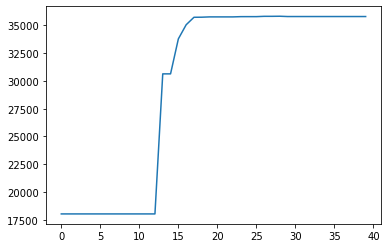

In [100]:
X = loadBalancer.X[-1,:]
X
pred = []
for n  in range(0,40):
    X_ = np.append(X[:-1], n)
    rewardHat = loadBalancer.model.predict(X_[None,:])[0]
    pred.append(rewardHat)

plt.plot(range(0,40), pred)

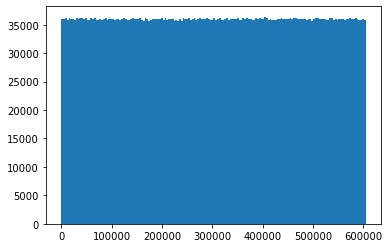

In [69]:
plt.hist(env.logTime['arrivalEvent'], bins=7*24);

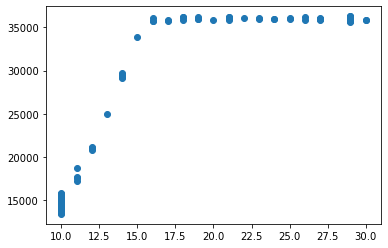

In [85]:
plt.scatter(env.log['numberOfServers'][::2], env.log['reward'])

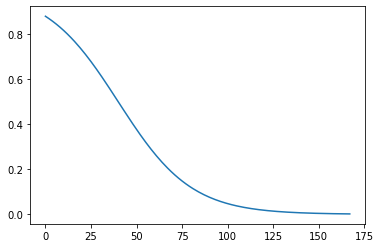

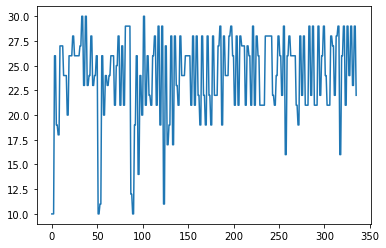

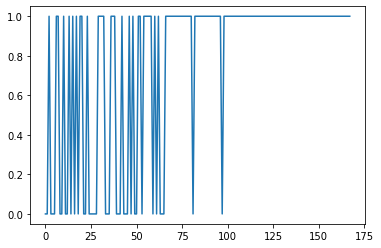

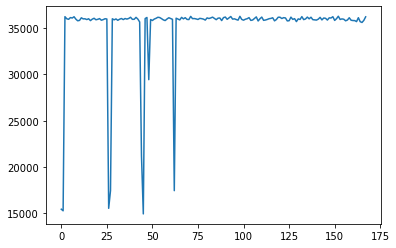

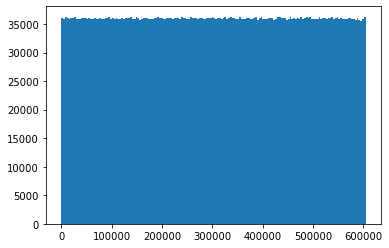

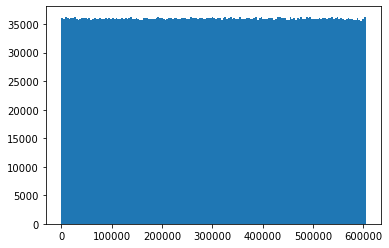

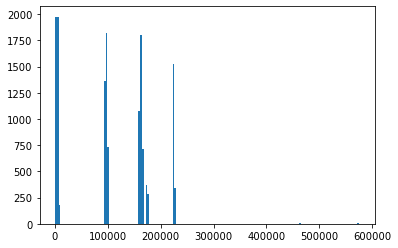

In [96]:
plt.plot(env.log['eta'])
plt.figure()
plt.plot(env.log['numberOfServers'])
plt.figure()
plt.plot(env.log['greedyEpsilonActionType'])
plt.figure()
plt.plot(env.log['reward'])
plt.figure()
plt.hist(env.logTime['arrivalEvent'], bins=int(stopTime/60/60));
plt.figure()
plt.hist(env.logTime['requestProcessed'], bins=int(stopTime/60/60));
plt.figure()
plt.hist(env.logTime['requestCancelled'], bins=int(stopTime/60/60));

Text(0, 0.5, 'y')

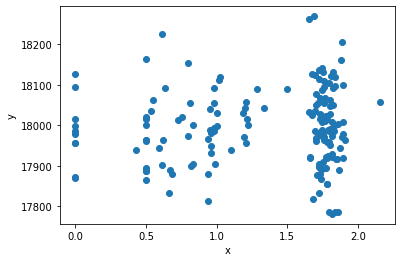

In [14]:
plt.scatter(loadBalancer.X[:-1,0],loadBalancer.y)
plt.xlabel('x')
plt.ylabel('y')

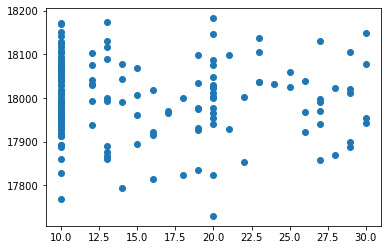

In [52]:
plt.scatter(env.log['numberOfServers'][0::2],env.log['reward'])

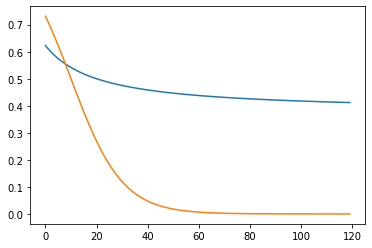

In [31]:

def sigmoid(x):
      return 1 / (1 + np.exp(-x))

x = np.arange(0,120,1)
plt.plot(x, sigmoid(2/(0.1*x+2)-0.5))
plt.plot(x, sigmoid(1-0.1*x))

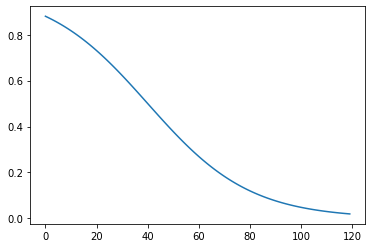

In [38]:
x = np.arange(0,120,1)
plt.plot(x, sigmoid(2-0.05*x))